In [4]:
import matplotlib.pyplot as mpl
import scipy.cluster.hierarchy as sch,random,numpy as np,pandas as pd
from scipy.spatial.distance import squareform
from scipy.stats import norm, multivariate_normal, kendalltau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### HRP code from the paper (Lopez de Prada 2016)

You can run it with run_hrp_artificial_data() and play with artificially generated data parameters to get intuition about how HRP works.

Also contains slightly modified clean_covariance_matrix() from part 2 and function build_hrp which takes in real data.

UPD:
- build_hrp_with_dependence_distance() takes different distance metrics and copula types as parameters (part 4 a, b)

In [ ]:
def getIVP(cov,**kargs):
    # Compute the inverse-variance portfolio
    ivp=1./np.diag(cov)
    ivp/=ivp.sum()
    return ivp


def getClusterVar(cov,cItems):
    # Compute variance per cluster
    cov_=cov.loc[cItems,cItems] # matrix slice
    w_=getIVP(cov_).reshape(-1,1)
    cVar=np.dot(np.dot(w_.T,cov_),w_)[0,0]
    return cVar

def getQuasiDiag(link):
    # Sort clustered items by distance
    link = link.astype(int)
    sortIx = pd.Series([link[-1, 0], link[-1, 1]])
    numItems = link[-1, 3]  # number of original items
    while sortIx.max() >= numItems:
        sortIx.index = range(0, sortIx.shape[0] * 2, 2)  # make space
        df0 = sortIx[sortIx >= numItems]  # find clusters

        i = df0.index
        j = df0.values - numItems
        sortIx[i] = link[j, 0]  # item 1
        df0 = pd.Series(link[j, 1], index=i + 1)
        sortIx = pd.concat([sortIx, df0]).sort_index()  # concatenate instead of append
        sortIx.index = range(sortIx.shape[0])  # re-index
    return sortIx.tolist()

def getRecBipart(cov,sortIx):
    # Compute HRP alloc
    w=pd.Series(1,index=sortIx, dtype=float)
    cItems=[sortIx] # initialize all items in one cluster
    while len(cItems)>0:
        cItems=[elem[j:k] for elem in cItems for j,k in \
                ((0,len(elem)//2), (len(elem)//2,len(elem))) if len(elem)>1] # bi-section
        # print("humus", len(cItems), cItems)
        for i in range(0,len(cItems),2): # parse in pairs
            cItems0=cItems[i] # cluster 1
            cItems1=cItems[i+1] # cluster 2
            cVar0=getClusterVar(cov,cItems0)
            cVar1=getClusterVar(cov,cItems1)
            alpha=1-cVar0/(cVar0+cVar1)
            w[cItems0]*=alpha # weight 1
            w[cItems1]*=1-alpha # weight 2
    return w

def correlDist(corr):
    # A distance matrix based on correlation, where 0<=d[i,j]<=1
    # This is a proper distance metric
    dist=((1-corr)/2.)**.5 # distance matrix
    return dist


def plotCorrMatrix(path,corr,labels=None):
    # Heatmap of the correlation matrix
    if labels is None:labels=[]
    mpl.pcolor(corr)
    mpl.colorbar()
    mpl.yticks(np.arange(.5,corr.shape[0]+.5),labels)
    mpl.xticks(np.arange(.5,corr.shape[0]+.5),labels)
    mpl.savefig(path)
    mpl.clf();mpl.close() # reset pylab
    return

def generateData(nObs,size0,size1,sigma1):
    # Time series of correlated variables
    #1) generating some uncorrelated data
    np.random.seed(seed=12345);random.seed(12345)
    x=np.random.normal(0,1,size=(nObs,size0)) # each row is a variable
    #2) creating correlation between the variables
    cols=[random.randint(0,size0-1) for i in range(size1)]
    y=x[:,cols]+np.random.normal(0,sigma1,size=(nObs,len(cols)))
    x=np.append(x,y,axis=1)
    x=pd.DataFrame(x,columns=range(1,x.shape[1]+1))
    print(x.shape)
    return x,cols

def run_hrp_artificial_data():
    #1) Generate correlated data
    nObs,size0,size1,sigma1=250,5,5,.25
    x,cols=generateData(nObs,size0,size1,sigma1) # x is of size 10000 by 10 (250 by 14?)
    print([(j+1,size0+i) for i,j in enumerate(cols,1)])
    
    #2) compute and plot correl matrix
    cov,corr=x.cov(),x.corr()
    # plotCorrMatrix('HRP3_corr0.png',corr,labels=corr.columns)
    
    # 3) cluster
    dist=correlDist(corr)
    condensed_dist_matrix = squareform(dist)
    link=sch.linkage(condensed_dist_matrix,'single')
    fig = plt.figure(figsize=(25, 10))
    dn = sch.dendrogram(link)
    plt.show()
    sortIx=getQuasiDiag(link)
    sortIx=corr.index[sortIx].tolist() # recover labels
    df0=corr.loc[sortIx,sortIx] # reorder
    # plotCorrMatrix('HRP3_corr1.png',df0,labels=df0.columns)
    
    #4) Capital allocation
    hrp=getRecBipart(cov,sortIx)
    print(hrp)


def clean_covariance_matrix(cov_matrix: pd.DataFrame, clip_threshold=1e-3):
    # Eigen decomposition (values and vectors as NumPy arrays)
    eigvals, eigvecs = np.linalg.eigh(cov_matrix.values)

    # Clip small eigenvalues
    eigvals = np.clip(eigvals, clip_threshold, None)

    # Reconstruct the cleaned covariance matrix
    cleaned_matrix = eigvecs @ np.diag(eigvals) @ eigvecs.T

    # Return as a DataFrame with original index/columns
    cleaned_df = pd.DataFrame(cleaned_matrix, index=cov_matrix.index, columns=cov_matrix.columns)

    return cleaned_df

def build_hrp(data, clean_cov_matrix=False):
    #1) compute and plot correl matrix
    cov,corr=data.cov(),data.corr()

    #2) clean covariance matrix (eigen clipping)
    if clean_cov_matrix:
        cov = clean_covariance_matrix(cov, clip_threshold=0.001)
    # plotCorrMatrix('HRP3_corr0.png',corr,labels=corr.columns)

    # 3) cluster
    dist=correlDist(corr)
    condensed_dist_matrix = squareform(dist) 
    link=sch.linkage(condensed_dist_matrix,'single')
    fig = plt.figure(figsize=(25, 10))
    dn = sch.dendrogram(link)
    plt.show()
    sortIx=getQuasiDiag(link)
    sortIx=corr.index[sortIx].tolist() # recover labels
    df0=corr.loc[sortIx,sortIx] # reorder
    # plotCorrMatrix('HRP3_corr1.png',df0,labels=df0.columns)
    
    #4) Capital allocation
    hrp=getRecBipart(cov,sortIx)
    return hrp


def bar_plot(pd_weights):
# Create bar plot
    plt.figure(figsize=(12, 6))
    pd_weights.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title("Asset Weights")
    plt.ylabel("Weight")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def gaussian_copula_factory(x, y):
    """Returns a Gaussian copula C(u, v) from ranked inputs x and y."""
    norm_x = norm.ppf(x)
    norm_y = norm.ppf(y)
    rho = np.corrcoef(norm_x, norm_y)[0, 1]
    
    def C(u, v):
        u = np.clip(u, 1e-10, 1 - 1e-10)
        v = np.clip(v, 1e-10, 1 - 1e-10)
        mean = [0, 0]
        cov = [[1, rho], [rho, 1]]
        upper = [norm.ppf(u), norm.ppf(v)]
        return multivariate_normal.cdf(upper, mean=mean, cov=cov)
    
    return C

def gumbel_copula_factory(x, y):
    """Returns a Gumbel copula C(u, v) from ranked inputs x and y."""
    # Estimate Kendall's tau
    tau, _ = kendalltau(x, y)
    # Invert tau = 1 - 1/β ⇒ β = 1 / (1 - τ)
    beta = 1 / (1 - tau) if tau < 1 else 20  # cap β if tau ~ 1
    
    def C(u, v):
        # Avoid log(0)
        u = np.clip(u, 1e-10, 1 - 1e-10)
        v = np.clip(v, 1e-10, 1 - 1e-10)
        logu = -np.log(u)
        logv = -np.log(v)
        return np.exp(-((logu**(1/beta) + logv**(1/beta))**beta))
    
    return C

def empirical_copula_factory(x, y):
    """Returns an empirical copula C(u, v) from ranked inputs x and y."""
    x_rank = pd.Series(x).rank(pct=True).values
    y_rank = pd.Series(y).rank(pct=True).values
    
    def C(u, v):
        """
        Empirical copula: C(u,v) = (1/n) * sum(I(F_X(X_i) <= u, F_Y(Y_i) <= v))
        """
        return np.mean((x_rank <= u) & (y_rank <= v))
    
    return C

def d1_schweizer_wolff(copula_func, grid_size=20):
    """
    Compute the δ₁ Schweizer-Wolff dependence measure:
    δ₁(X,Y) = 12 ∫₀¹∫₀¹ |C(u,v) - uv| du dv
    """
    u_vals = np.linspace(0, 1, grid_size)
    v_vals = np.linspace(0, 1, grid_size)
    du = 1.0 / (grid_size - 1)
    dv = 1.0 / (grid_size - 1)
    
    integral = 0.0
    for i, u in enumerate(u_vals):
        for j, v in enumerate(v_vals):
            integral += abs(copula_func(u, v) - u * v) * du * dv
    
    return 12 * integral

def d2_schweizer_wolff(copula_func, grid_size=20):
    """
    Compute the δ₂ Schweizer-Wolff dependence measure:
    δ₂(X,Y) = (90 ∫₀¹∫₀¹ |C(u,v) - uv|² du dv)^(1/2)
    """
    u_vals = np.linspace(0, 1, grid_size)
    v_vals = np.linspace(0, 1, grid_size)
    du = 1.0 / (grid_size - 1)
    dv = 1.0 / (grid_size - 1)
    
    integral = 0.0
    for i, u in enumerate(u_vals):
        for j, v in enumerate(v_vals):
            diff = copula_func(u, v) - u * v
            integral += (diff ** 2) * du * dv
    
    return np.sqrt(90 * integral)

def d3_schweizer_wolff(copula_func, grid_size=50):
    """
    Compute the δ₃ Schweizer-Wolff dependence measure:
    δ₃(X,Y) = 4 sup_{u,v∈[0,1]} |C(u,v) - uv|
    """
    u_vals = np.linspace(0, 1, grid_size)
    v_vals = np.linspace(0, 1, grid_size)
    max_diff = 0.0
    
    for u in u_vals:
        for v in v_vals:
            diff = abs(copula_func(u, v) - u * v)
            if diff > max_diff:
                max_diff = diff
    
    return 4 * max_diff

def compute_dependence_distance_matrix(df, copula_type="empirical", method="d1", grid_size=20):
    """
    Compute a matrix of dependence measures between all pairs of columns in the dataframe.
    
    Parameters:
    -----------
    df : pandas DataFrame
        Input data
    copula_type : str
        Type of copula to use: "empirical", "gaussian", or "gumbel"
    method : str
        Dependence measure to use: "d1", "d2", or "d3"
    grid_size : int
        Number of grid points for numerical integration
        
    Returns:
    --------
    pandas DataFrame
        Matrix of dependence measures
    """
    n = df.shape[1]
    cols = df.columns
    mat = np.zeros((n, n))
    
    for i in range(n):
        for j in range(i + 1, n):
            x = df.iloc[:, i].values
            y = df.iloc[:, j].values
            
            # Rank transform the data (empirical CDF)
            x_rank = pd.Series(x).rank(pct=True).values
            y_rank = pd.Series(y).rank(pct=True).values
            
            # Choose copula type
            if copula_type == "empirical":
                C = empirical_copula_factory(x, y)
            elif copula_type == "gaussian":
                C = gaussian_copula_factory(x_rank, y_rank)
            elif copula_type == "gumbel":
                C = gumbel_copula_factory(x_rank, y_rank)
            else:
                raise ValueError("Unknown copula type: choose 'empirical', 'gaussian', or 'gumbel'")
            
            # Choose dependence measure
            if method == "d1":
                d = d1_schweizer_wolff(C, grid_size)
            elif method == "d2":
                d = d2_schweizer_wolff(C, grid_size)
            elif method == "d3":
                d = d3_schweizer_wolff(C, grid_size)
            else:
                raise ValueError("Unknown method: choose 'd1', 'd2', or 'd3'")
                
            mat[i, j] = mat[j, i] = d
    
    return pd.DataFrame(mat, index=cols, columns=cols)

# --- HRP with custom distance matrix ---
def custom_hrp(data, dist_matrix):
    cov = data.cov()
    cov = clean_covariance_matrix(cov)

    condensed_dist_matrix = squareform(dist_matrix)
    link = sch.linkage(condensed_dist_matrix, method='single')
    
    # fig = plt.figure(figsize=(25, 10))
    # dn = sch.dendrogram(link)
    # plt.show()
    
    sortIx = getQuasiDiag(link)
    sortIx = dist_matrix.index[sortIx].tolist()
    return getRecBipart(cov, sortIx).sort_values(ascending=False)

def build_hrp_with_dependence_distance(df, dist_metric='d1', copula_type="empirical", grid_size=20):
    dist_matrix = compute_dependence_distance_matrix(df, method=dist_metric,copula_type="empirical", grid_size=grid_size)
    return custom_hrp(df, dist_matrix)
    

(250, 10)
[(4, 6), (1, 7), (3, 8), (3, 9), (2, 10)]


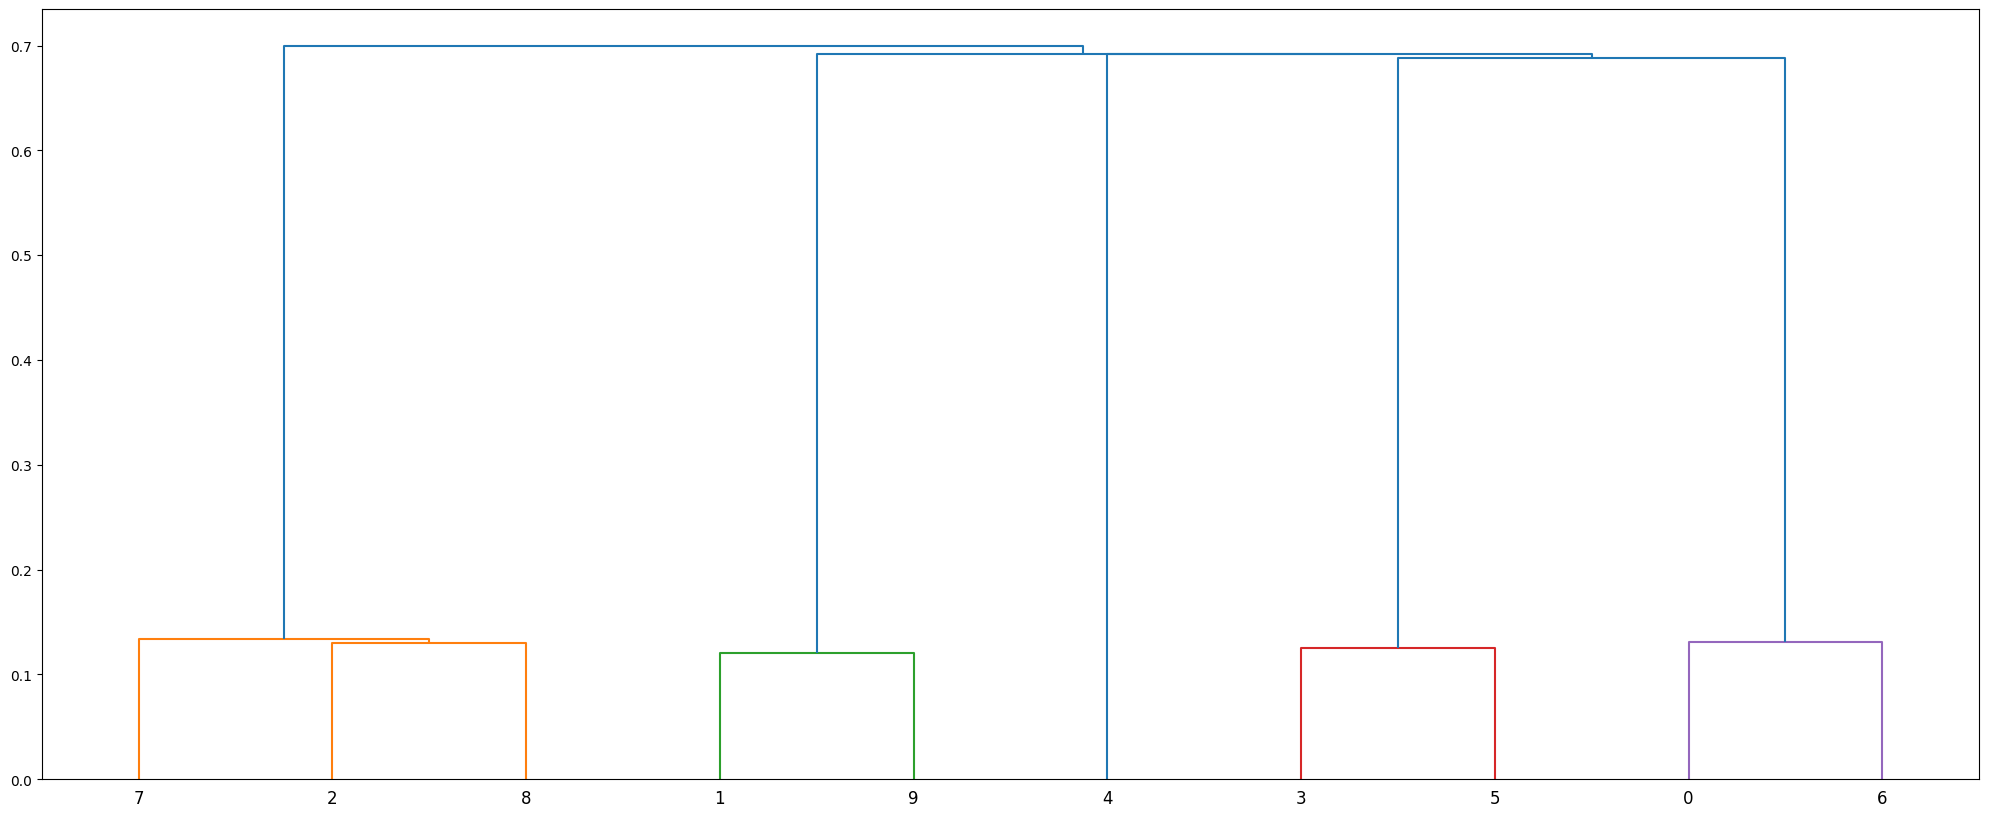

8     0.071549
3     0.075943
9     0.132707
2     0.062382
10    0.060744
5     0.188556
4     0.140235
6     0.122260
1     0.074824
7     0.070800
dtype: float64


In [6]:
run_hrp_artificial_data()

### Load our data
Preprocess it as you wish (e.g. excluding weekdays)

In [7]:
prices = pd.read_csv('../data/dataset.csv', sep=',')

prices['Date'] = pd.to_datetime(prices['Date'], format='%d.%m.%Y')
prices.set_index('Date', inplace=True)
print("All prices", prices.shape)

datePP = '2021-09-11'
dateTr = '2022-11-21'

weekdays_only = prices[prices.index.weekday < 5]
print("weekday prices", weekdays_only.shape)


log_returns = np.log(weekdays_only / weekdays_only.shift(1)).dropna()


window_size = 250

window_pp = log_returns.loc[:datePP].iloc[-window_size:]
window_tr = log_returns.loc[:dateTr].iloc[-window_size:]

print("Window of log returns data", window_pp.shape)


All prices (2728, 14)
weekday prices (1949, 14)
Window of log returns data (250, 14)


Run HRP foro datePP and dateTR

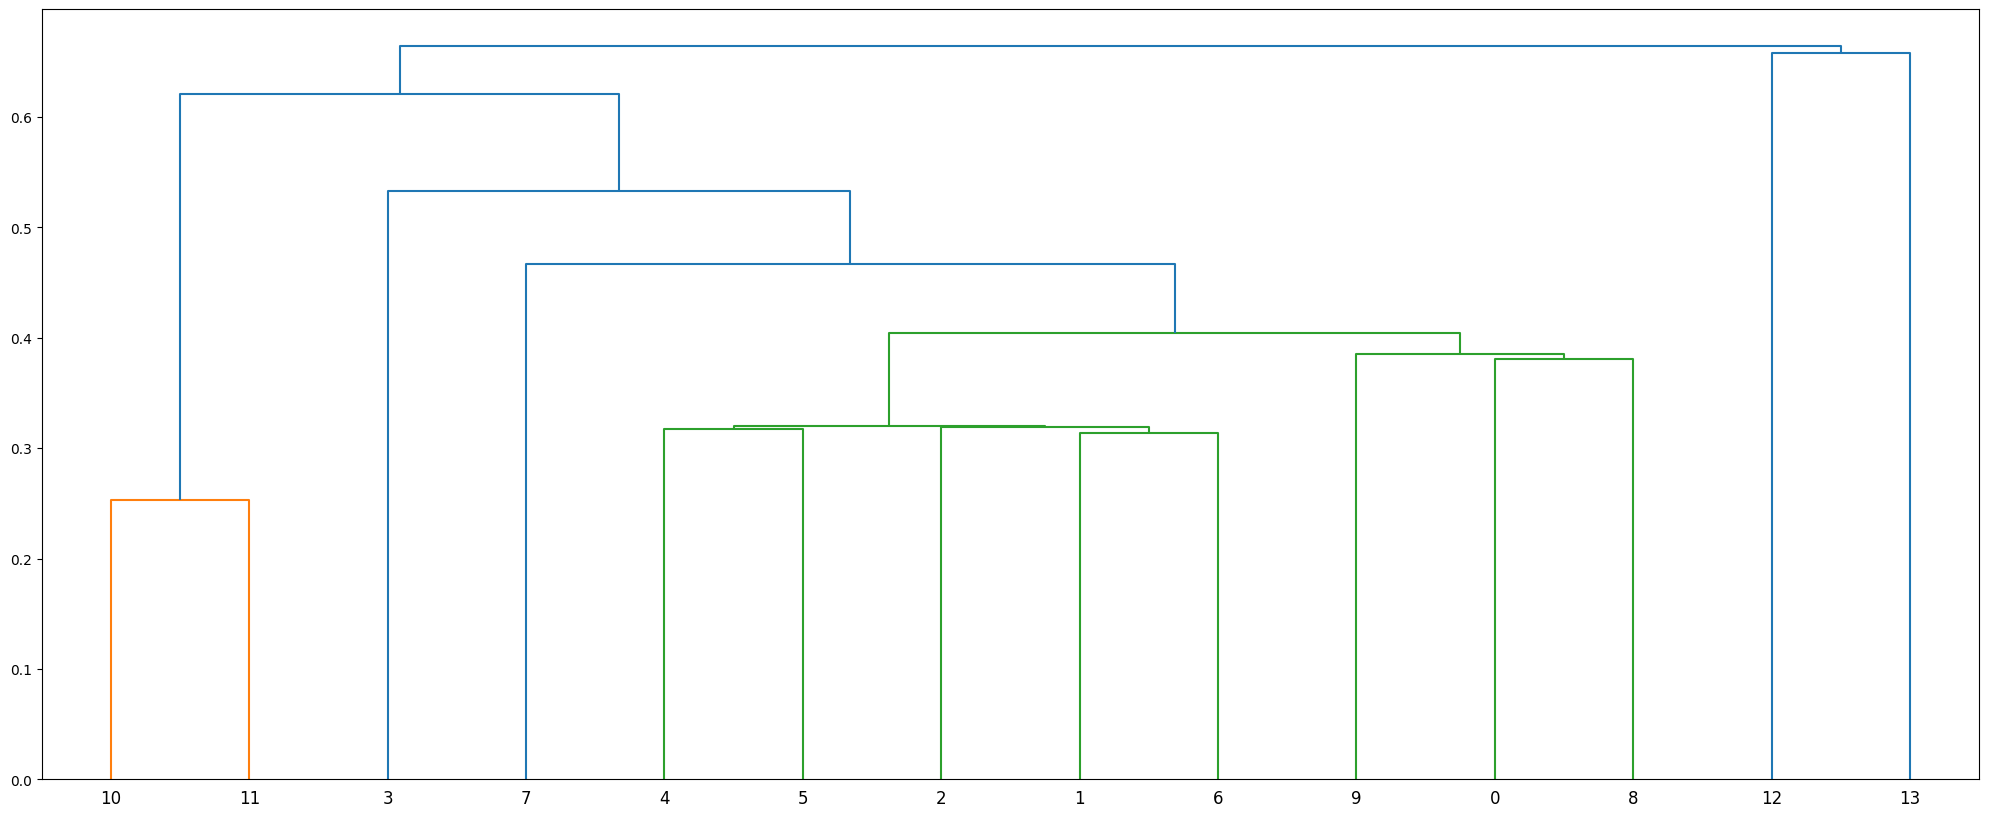

SPXT        0.257797
XCMP        0.250656
DOGE-USD    0.010491
MANA-USD    0.011136
ETH-USD     0.021857
LINK-USD    0.014913
BTC-USD     0.036752
BCH-USD     0.023689
LTC-USD     0.017481
XRP-USD     0.008752
ADA-USD     0.022773
XLM-USD     0.017923
SOFR        0.263781
VIX         0.041998
dtype: float64


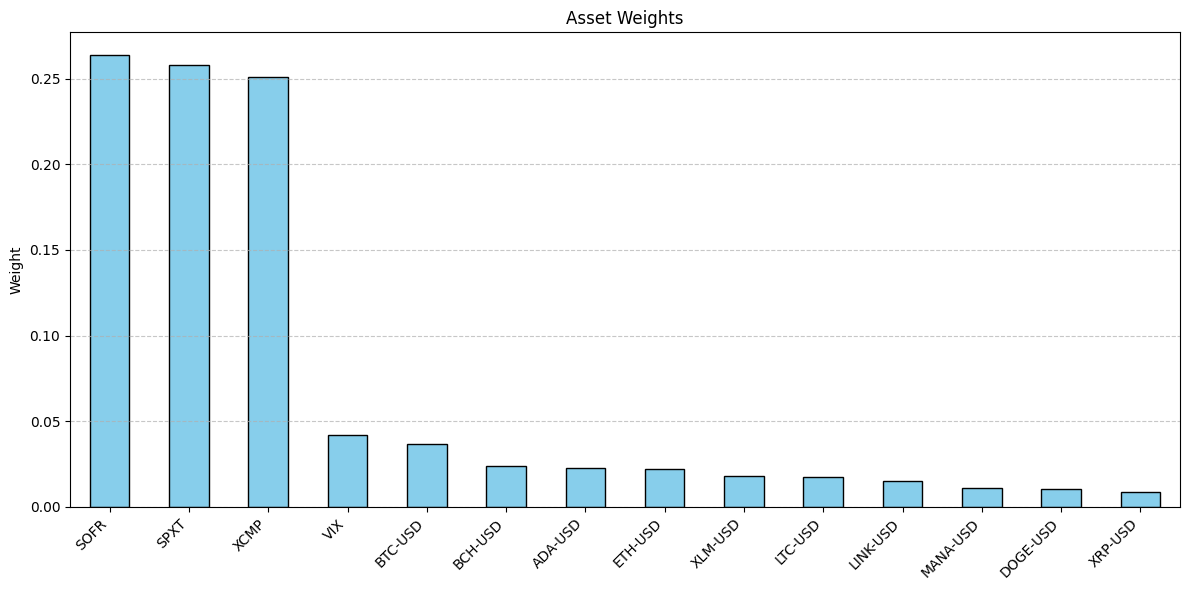

In [8]:
# excluded = ['SOFR', 'XCMP', 'SPXT', 'VIX']
# excluded = ['SOFR', 'XCMP', 'SPXT']
excluded = []
df_filtered = window_pp.drop(columns=excluded)

hrp = build_hrp(df_filtered, clean_cov_matrix=True)
print(hrp)
bar_plot(hrp)

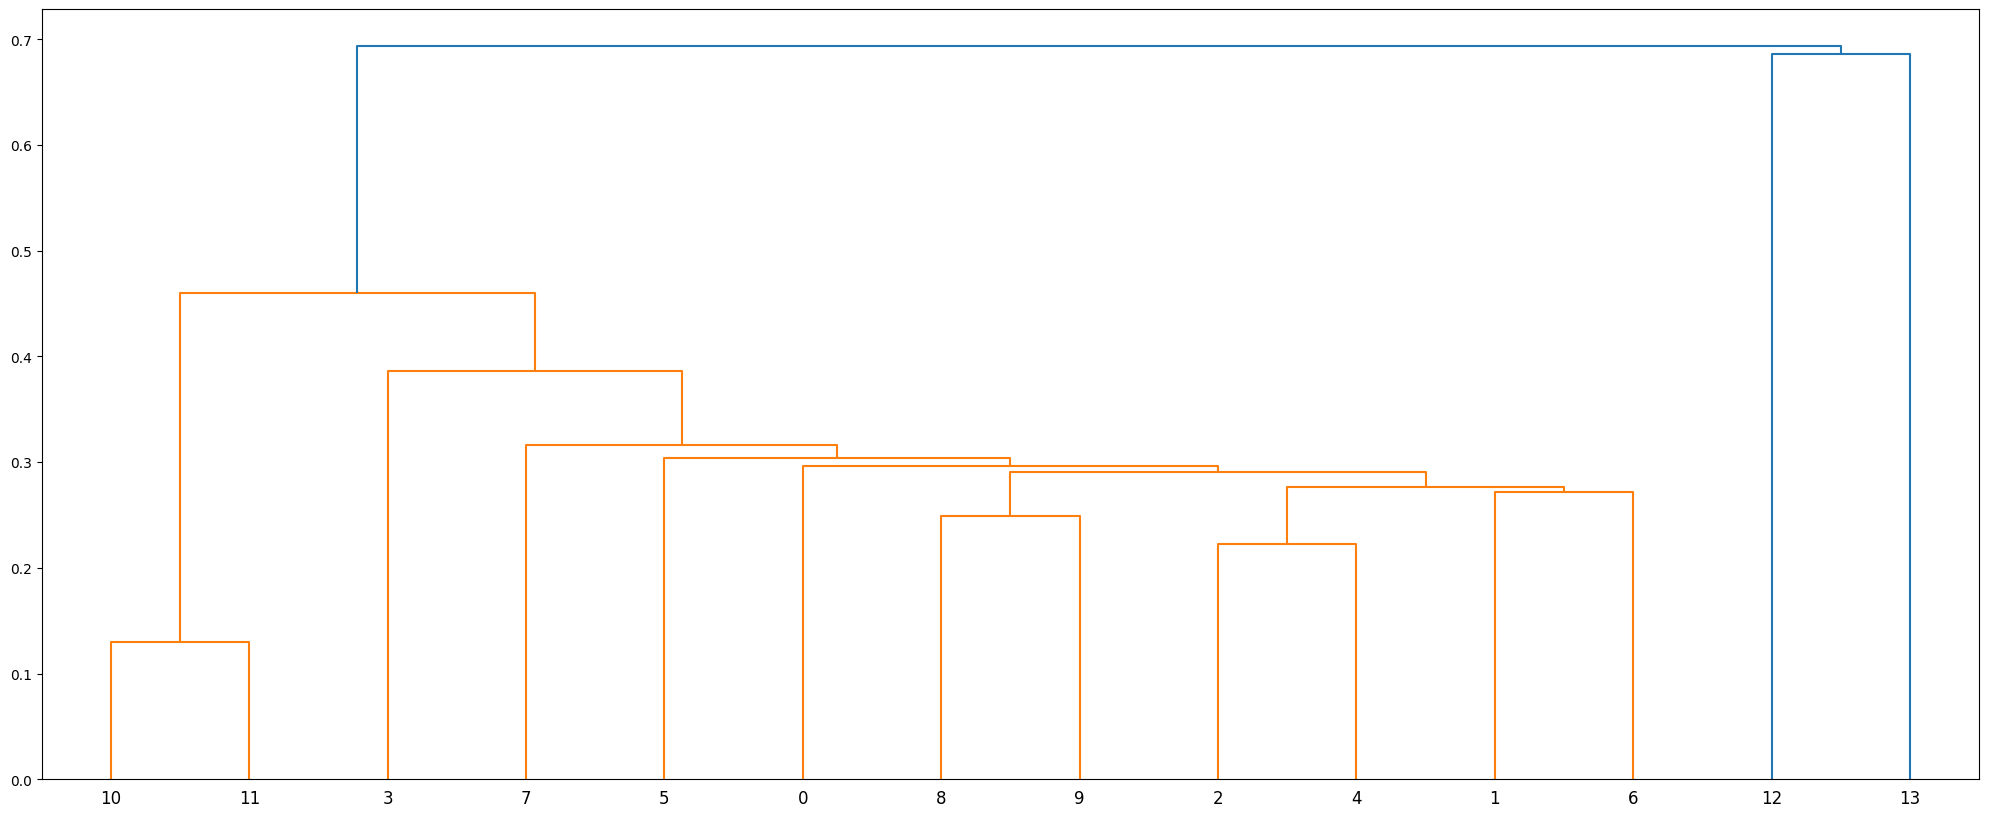

SPXT        0.179618
XCMP        0.138837
DOGE-USD    0.037200
MANA-USD    0.014904
LINK-USD    0.016786
ADA-USD     0.019624
XLM-USD     0.024074
XRP-USD     0.046677
BTC-USD     0.038471
ETH-USD     0.025920
BCH-USD     0.050350
LTC-USD     0.050402
SOFR        0.295633
VIX         0.061505
dtype: float64


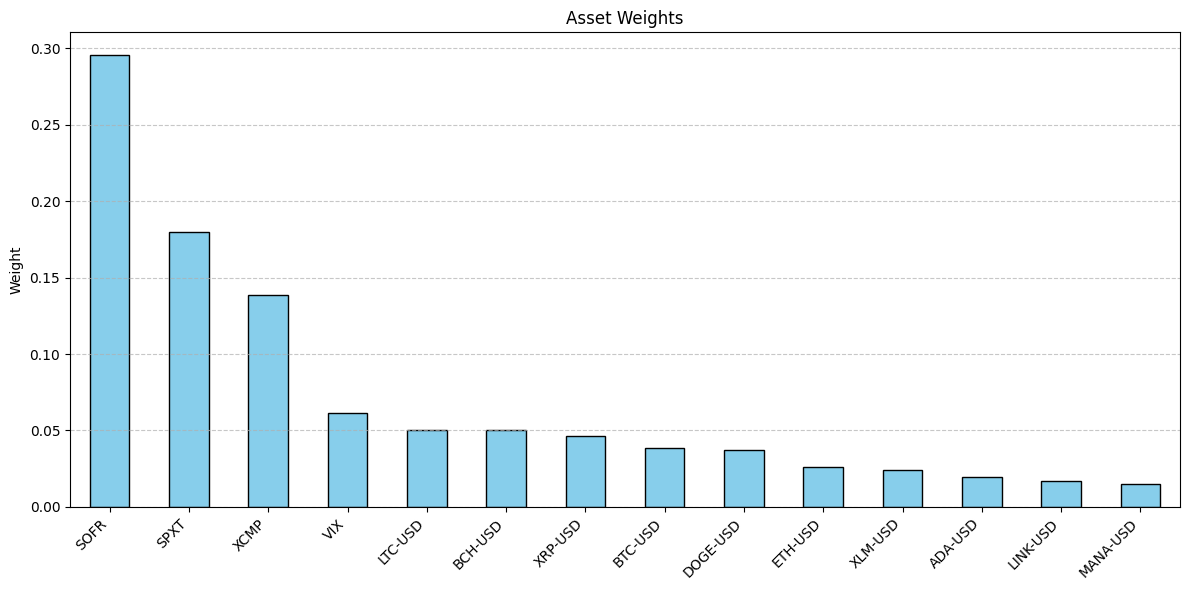

In [12]:
df_filtered = window_tr.drop(columns=excluded)

hrp = build_hrp(df_filtered, clean_cov_matrix=True)
print(hrp)
bar_plot(hrp)

### Distance metrics experiments

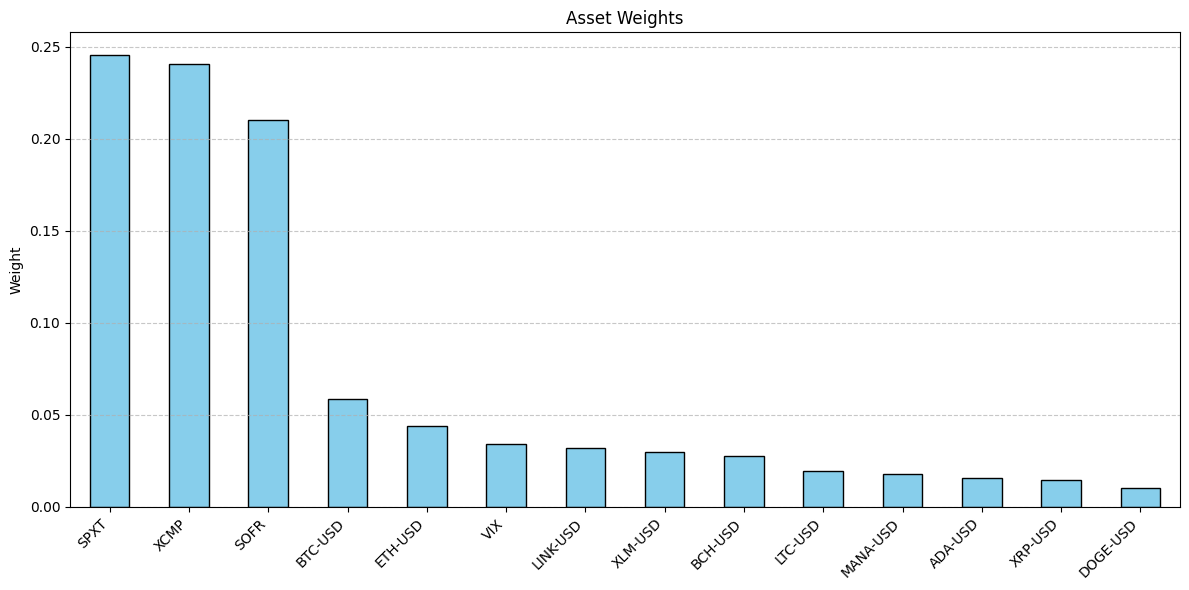

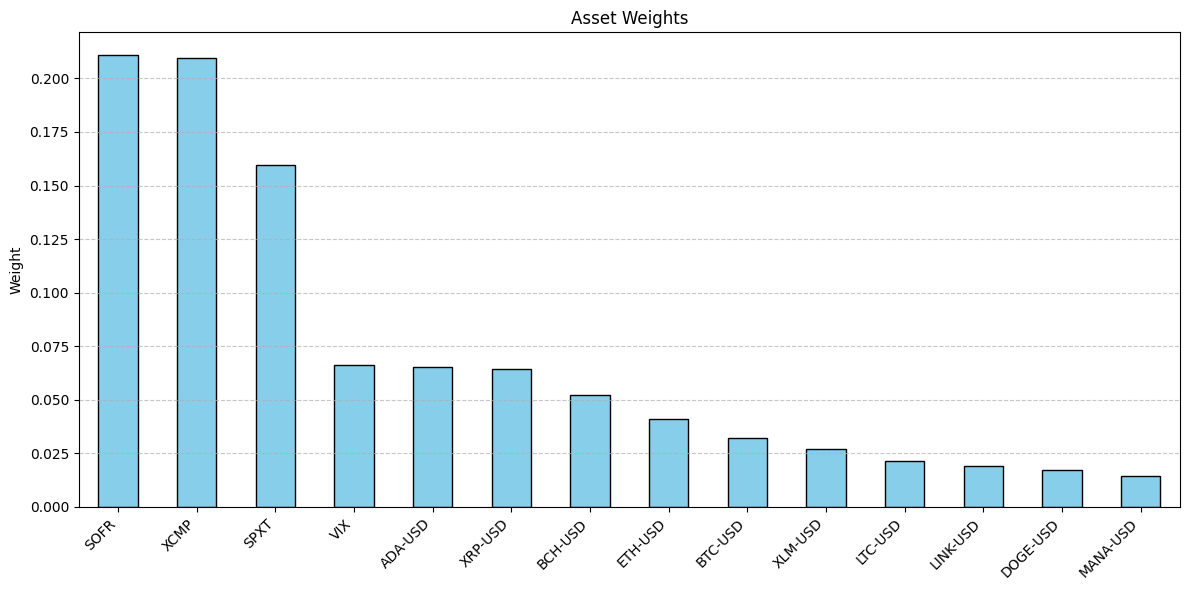

In [15]:
# excluded = ['SOFR', 'XCMP', 'SPXT', 'VIX']
excluded = []

df_filtered = window_pp.drop(columns=excluded)

weights = build_hrp_with_dependence_distance(df_filtered, dist_metric='d3', copula_type='gaussian')
bar_plot(weights)

df_filtered = window_tr.drop(columns=excluded)

weights = build_hrp_with_dependence_distance(df_filtered, dist_metric='d3', copula_type='gaussian')
bar_plot(weights)

In [16]:
# excluded = ['SOFR', 'XCMP', 'SPXT', 'VIX']
excluded = []

df_filtered = window_pp.drop(columns=excluded)

# Define possible values for dist_metric and copula_type
dist_metrics = ['d1', 'd2', 'd3']
copula_types = ['empirical', 'gaussian', 'gumbel']

# Initialize a dictionary to store weights
weights_dict = {}

# Loop through all combinations of dist_metric and copula_type
for dist_metric in dist_metrics:
    for copula_type in copula_types:
        print(f"Processing dist_metric={dist_metric}, copula_type={copula_type}")
        weights = build_hrp_with_dependence_distance(df_filtered, dist_metric=dist_metric, copula_type=copula_type)
        weights_dict[(dist_metric, copula_type)] = weights

# Convert weights_dict to a DataFrame for better visualization
weights_df = pd.DataFrame.from_dict(weights_dict, orient='index')
weights_df.index = pd.MultiIndex.from_tuples(weights_df.index, names=["dist_metric", "copula_type"])

# Save the weights to a CSV file
weights_df.to_csv('../output/weights_results_wolf_distances_pp.csv')

Processing dist_metric=d1, copula_type=empirical
Processing dist_metric=d1, copula_type=gaussian
Processing dist_metric=d1, copula_type=gumbel
Processing dist_metric=d2, copula_type=empirical
Processing dist_metric=d2, copula_type=gaussian
Processing dist_metric=d2, copula_type=gumbel
Processing dist_metric=d3, copula_type=empirical
Processing dist_metric=d3, copula_type=gaussian
Processing dist_metric=d3, copula_type=gumbel
